In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm 

In [2]:
class Planeta:
    
    def __init__(self, e, a, t):
        
        self.t = t
        self.dt = t[1] - t[0] # Paso del tiempo
        
        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor
        self.alpha = 1.1e-8
        
        self.G = 4*np.pi**2 # Unidades gaussianas
        
        self.r = np.zeros(2)
        self.v = np.zeros_like(self.r)
        
        self.r[0] = self.a_*(1+self.e)
        self.v[1] = np.sqrt( self.G*(1-self.e)/(self.a_*(1.+self.e)) )
        
        d = np.linalg.norm(self.r)
        self.a = (-self.G/d**3)*self.r*(1+self.alpha/np.square(d))
        
        self.R = np.zeros((len(t),len(self.r)))
        self.V = np.zeros_like(self.R)
        
        # El valor del pasado
        self.rp = self.r
        
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.GetAceleration()
        
        if i==0:
            self.v += self.dt*self.a
            self.r = self.rp + self.v*self.dt
        else:
            
            # rp pasado, r presente rf futuro
            self.rf = self.r + self.v*self.dt + 0.5*self.a*self.dt**2
            
            d = np.linalg.norm(self.rf)
            self.af = (-self.G/d**3)*self.rf*(1+self.alpha/np.square(d))
            
            self.v = self.v + (self.dt/2)*(self.af+self.a)
            
            self.rp = self.r
            self.r = self.rf
            self.a = self.af
            
    
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def SetVelocity(self,i):
        self.V[i] = self.v
        
    
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
    
    def GetAceleration(self):
        
        d = np.linalg.norm(self.r)
        self.a = (-self.G/d**3)*self.r*(1+self.alpha/np.square(d))
    
    def GetPerihelio(self):
        
        Dist = np.linalg.norm(self.R,axis=1)
        
        time = []
        x = []
        y = []
        
        for i in range(1,len(Dist)-1):
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]:
                time.append(self.t[i])
                x.append(self.R[i,0])
                y.append(self.R[i,1])
                
            
        return [time, x, y]

In [3]:
def GetPlanetas(t):
    
    Mercurio = Planeta(0.205630,0.387098,t)
    
    
    return [Mercurio]

In [4]:
dt = 1e-6
tmax = 2.5
t = np.arange(0.,tmax,dt)
Planetas = GetPlanetas(t)

In [5]:
def RunSimulation(t,Planetas):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        #print(it)
        for i in range(len(Planetas)):
            Planetas[i].Evolution(it)
            # Aca debes agregar la interaccion con la pared
            
            
    return Planetas

In [6]:
Planetas = RunSimulation(t,Planetas)

Running simulation: 100%|██████████| 2500000/2500000 [01:07<00:00, 36990.53 Steps/s]


In [7]:
Datos = Planetas[0].GetPerihelio()

In [8]:
#Tiempos en que llega al perihelio
Datos[0]

[0.120421,
 0.36126199999999997,
 0.602104,
 0.8429449999999999,
 1.083787,
 1.324628,
 1.56547,
 1.806311,
 2.047153,
 2.287995]

In [9]:
#Posición en X en cada perihelio
Datos[1]

[-0.3074989969955475,
 -0.3074989969928673,
 -0.307498996998013,
 -0.3074989969900397,
 -0.307498997000381,
 -0.3074989969870101,
 -0.30749899700242966,
 -0.30749899698376576,
 -0.3074989970043389,
 -0.30749899692574023]

In [10]:
#Posición en Y en cada perihelio
Datos[2]

[-3.016421437677733e-06,
 3.392016174120093e-06,
 -2.6408266082884983e-06,
 3.767610762506049e-06,
 -2.2652312889476735e-06,
 4.143206745732572e-06,
 -1.8896356139680297e-06,
 4.518802378359453e-06,
 -1.5140394847560535e-06,
 -7.54688105198095e-06]

In [11]:
Tiempos = np.array(Datos[0])
X = Datos[1]
Y = Datos[2]
Angulos = np.zeros(len(X))

for i in range(len(Angulos)):
    Angulos[i] = np.arctan(Y[i]/X[i])+np.pi

"""
deltaAngulos = np.zeros(len(Angulos))

deltaAngulos[0] = 0.

for i in range(1, len(deltaAngulos)):
    deltaAngulos[i] = np.abs(Angulos[i]-Angulos[i-1]) + deltaAngulos[i-1]

Tiempos
"""

'\ndeltaAngulos = np.zeros(len(Angulos))\n\ndeltaAngulos[0] = 0.\n\nfor i in range(1, len(deltaAngulos)):\n    deltaAngulos[i] = np.abs(Angulos[i]-Angulos[i-1]) + deltaAngulos[i-1]\n\nTiempos\n'

In [12]:
Angulos*(180/np.pi)

array([180.00056204, 179.99936797, 180.00049206, 179.99929799,
       180.00042208, 179.999228  , 180.00035209, 179.99915802,
       180.00028211, 180.0014062 ])

In [13]:
#implementamos minimos cuadrados

Angulos = Angulos*(180/np.pi)
#deltaAngulos = deltaAngulos*(180/np.pi)

n = len(Tiempos)

m = (n * np.sum(Tiempos * Angulos) - np.sum(Tiempos) * np.sum(Angulos)) / (n * np.sum(Tiempos**2) - (np.sum(Tiempos))**2)

m_segundos = m * (3600/1) * (100/1)

"""
m = (n * np.sum(Tiempos * deltaAngulos) - np.sum(Tiempos) * np.sum(deltaAngulos)) / (n * np.sum(Tiempos**2) - (np.sum(Tiempos))**2)

regresion = m * Tiempos
"""

m_segundos

84.19920476180025

<IPython.core.display.Javascript object>


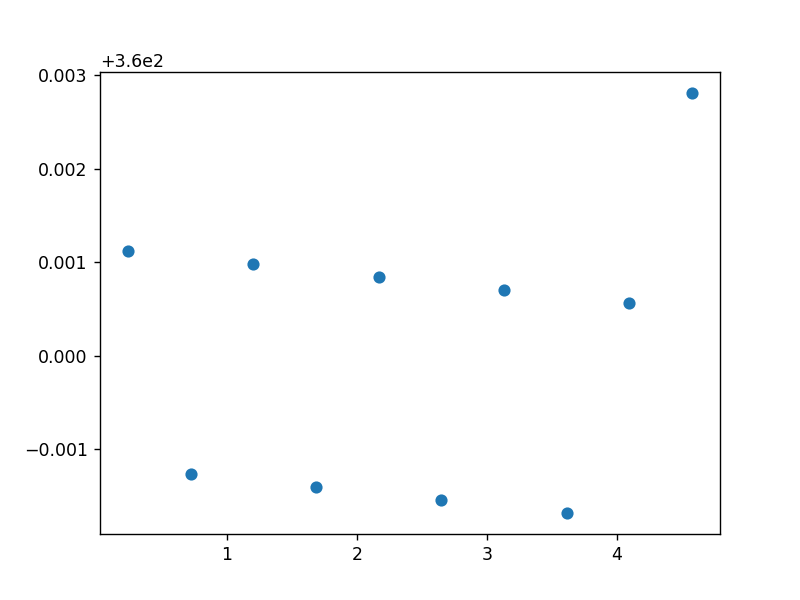

In [14]:
plt.scatter(Tiempos*2,Angulos*2)
#plt.plot(Tiempos,regresion)

In [15]:
A = np.vstack([Tiempos, np.ones(len(Tiempos))]).T

In [16]:
m, c = np.linalg.lstsq(A, Angulos, rcond=None)[0]

In [17]:
m*(3600/1)*(100/1)

84.19920478207067